13345243
2021-10-03 08:56:48
9795 total approvals, 10995 total swaps
9064 first approvals, 7202 first swaps
4249 matched pairs (3528 sequential, 721 gapped)
mean delay = 2068.2


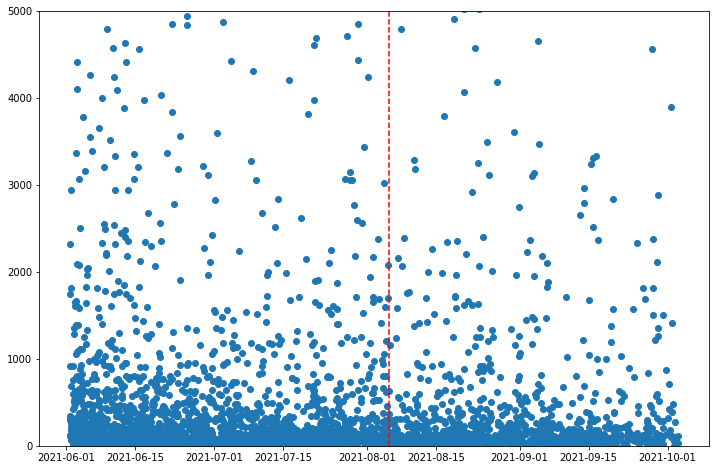

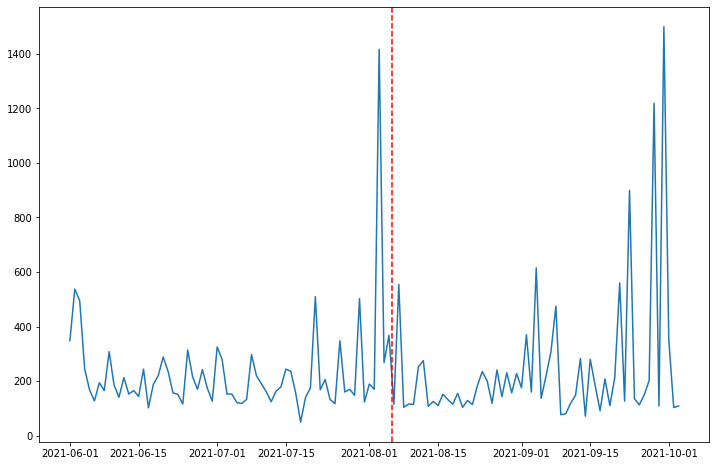

In [1]:
import requests
from jsonrpcclient import request
import csv
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter

ERIGON_URL = "http://192.168.1.104:8545/"
APPROVALS_FILE = 'uni_uniswapv2_approvals_with_nonce.csv'
SWAPS_FILE = 'swaps_backup_with_nonce.csv'
LONDON_BLOCKNUM = 12965000
LONDON_DATETIME = datetime(2021,8,5,12,33,42)

approvals = {}
swaps = {}

total_approvals = total_swaps = 0

with open(APPROVALS_FILE) as f:
    reader = csv.reader(f)
    for row in reader:
        total_approvals += 1
        blocknum = int(row[0])
        timestamp = int(row[2])
        address = row[3]
        iserror = int(row[4])
        nonce = int(row[5])
        if iserror == 0 and address not in approvals:
            approvals[address] = [nonce, blocknum, timestamp]

with open(SWAPS_FILE) as f:
    reader = csv.reader(f)
    for row in reader:
        total_swaps += 1
        blocknum = int(row[0])
        timestamp = int(row[2])
        address = row[3]
        iserror = int(row[4])
        nonce = int(row[5])
        if address not in swaps:
            swaps[address] = [nonce, blocknum, timestamp]

print(blocknum)
print(datetime.utcfromtimestamp(timestamp))
            
examples = []
pre_london = []
post_london = []
sequential_count = gapped_count = sequential_sum_blocks = 0
for address in approvals:
    if address in swaps:
        n0, b0, t0 = approvals[address]
        n1, b1, t1 = swaps[address]
        if n1 - n0 == 1:
            sequential_count += 1
            sequential_sum_blocks += b1 - b0
            dt = datetime.utcfromtimestamp(t0)
            examples += [[dt, t1 - t0, b1 - b0]]
            if b0 < LONDON_BLOCKNUM:
                pre_london += [[(t1 - t0) / 60, b1 - b0]]
            else:
                post_london += [[(t1 - t0) / 60, b1 - b0]]
        if n1 - n0 != 1:
            gapped_count += 1

dts, wait_times, num_blocks = zip(*examples)
start_date = min(dts).date()
end_date = max(dts).date()
num_days = (end_date - start_date).days + 1

dates = [start_date + timedelta(days=i) for i in range(num_days)]
daily_examples_time = [[] for _ in range(num_days)]
daily_examples_blocks = [[] for _ in range(num_days)]

for dt, w, b in zip(dts, wait_times, num_blocks):
    daynum = (dt.date() - start_date).days
    daily_examples_time[daynum] += [w]
    daily_examples_blocks[daynum] += [b]
    
daily_median_time = [None] * num_days
daily_mean_time = [None] * num_days
daily_lq_time = [None] * num_days
daily_uq_time = [None] * num_days
for i, daily in enumerate(daily_examples_time):
    daily_lq_time[i] = np.quantile(daily, 0.25)
    daily_median_time[i] = np.quantile(daily, 0.5)
    daily_uq_time[i] = np.quantile(daily, 0.75)
    daily_mean_time[i] = np.mean(daily)

daily_median_blocks = [None] * num_days
daily_mean_blocks = [None] * num_days
daily_lq_blocks = [None] * num_days
daily_uq_blocks = [None] * num_days
for i, daily in enumerate(daily_examples_blocks):
    daily_lq_blocks[i] = np.quantile(daily, 0.25)
    daily_median_blocks[i] = np.quantile(daily, 0.5)
    daily_uq_blocks[i] = np.quantile(daily, 0.75)
    daily_mean_blocks[i] = np.mean(daily)

daily_time_df = pd.DataFrame({'median': daily_median_time, 'uq': daily_uq_time}, index=dates)
daily_blocks_df = pd.DataFrame({'median': daily_median_blocks, 'uq': daily_uq_blocks}, index=dates)
    
matched_count = sequential_count + gapped_count

print(f"{total_approvals} total approvals, {total_swaps} total swaps")
print(f"{len(approvals)} first approvals, {len(swaps)} first swaps")
print(f"{matched_count} matched pairs ({sequential_count} sequential, {gapped_count} gapped)")
print(f"mean delay = {sequential_sum_blocks / sequential_count:.1f}")

fig, ax = plt.subplots(figsize=(12,8))
x, times, blocks = zip(*examples)
ax.scatter(x, times)
ax.axvline(LONDON_DATETIME, color='r', linestyle='dashed')
ax.set_ylim(ymin=0, ymax=5000);

fig, ax = plt.subplots(figsize=(12,8))
daily_time_df['median'].plot(ax=ax)
ax.axvline(LONDON_DATETIME, color='r', linestyle='dashed')

3.1833333333333336
2.55


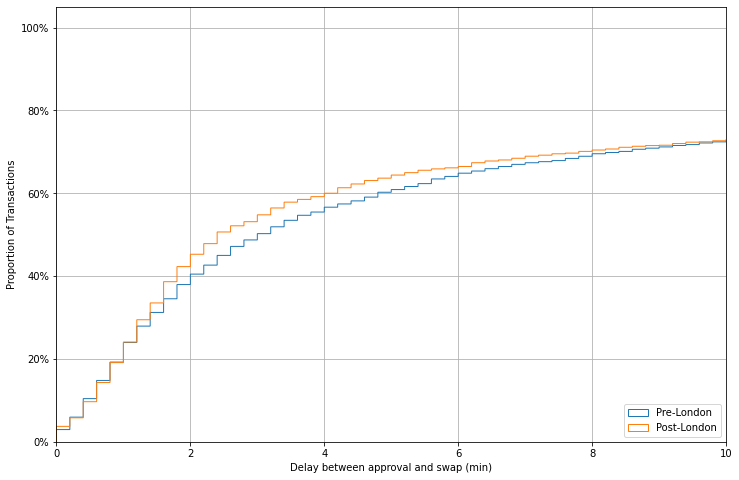

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
bins = [0.2*b for b in range(100001)]

pre_london_df = pd.DataFrame(pre_london, columns=['time','blocks'])
pre_london_df['time'].hist(bins=bins, ax=ax, density=True, histtype='step', cumulative=True, label='Pre-London')
print(pre_london_df['time'].quantile(0.5))

post_london_df = pd.DataFrame(post_london, columns=['time','blocks'])
post_london_df['time'].hist(bins=bins, ax=ax, density=True, histtype='step', cumulative=True, label='Post-London')
print(post_london_df['time'].quantile(0.5))

ax.set_xlim(xmin=0, xmax=10)
ax.set_xlabel('Delay between approval and swap (min)')
ax.set_ylabel('Proportion of Transactions')
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.legend(loc='lower right');